Experiment with seed: 1
parse_rule - 分解後: semantic_structure='S/_fuck(_bob,_david)/0', form='wgvt'
parse_rule - 分解後: semantic_structure='S/_get(_alice,_bob)/1', form='anbli'
parse_rule - 分解後: semantic_structure='S/_eat(_carol,_david)/0', form='jcrk'
parse_rule - 分解後: semantic_structure='S/_get(_carol,_david)/0', form='rlwv'
parse_rule - 分解後: semantic_structure='S/_fuck(_bob,_alice)/0', form='ulv'
clustering_rule_set - 分割結果: word_rule_set=[], sentence_rule_set=['S/_fuck(_bob,_david)/0->wgvt', 'S/_get(_alice,_bob)/1->anbli', 'S/_eat(_carol,_david)/0->jcrk', 'S/_get(_carol,_david)/0->rlwv', 'S/_fuck(_bob,_alice)/0->ulv']
parse_rule - 分解後: semantic_structure='S/_fuck(_bob,_david)/0', form='wgvt'
separate_rule_set_by_cv - 推論後: S/_fuck(_bob,_david)/0->wgvt
parse_rule - 分解後: semantic_structure='S/_get(_alice,_bob)/1', form='anbli'
separate_rule_set_by_cv - 推論後: S/_get(_alice,_bob)/1->anbli
parse_rule - 分解後: semantic_structure='S/_eat(_carol,_david)/0', form='jcrk'
separate_rule_set_by_cv - 推論

ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

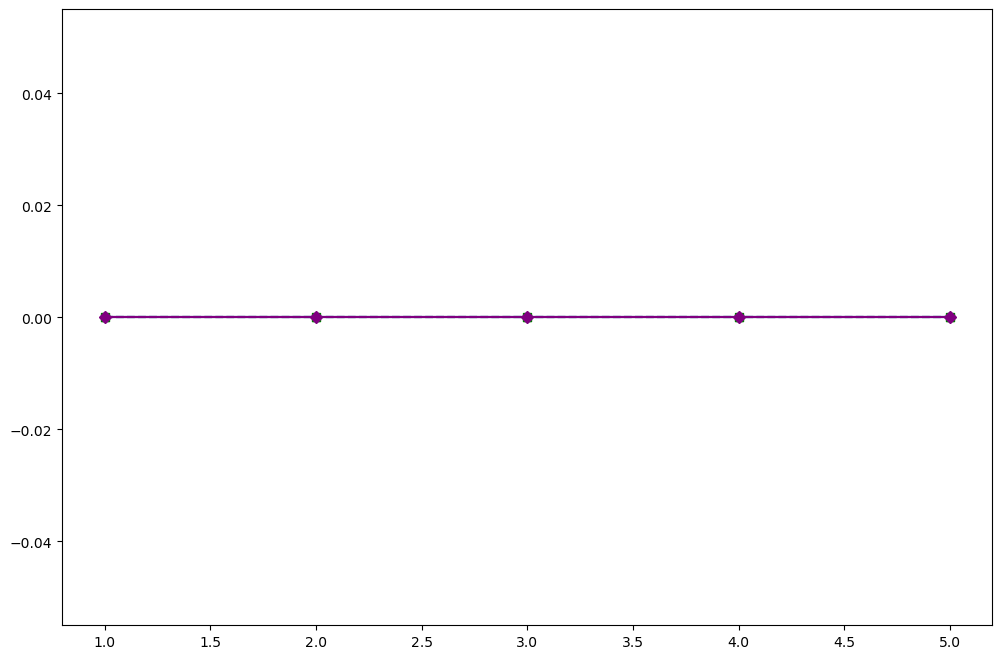

In [1]:
import json
import random
import os
from datetime import datetime
# from chunk.Chunk_with_CV import chunk_learning_with_cv, chunk_learning, set_induction_accuracy
from chunk.Chunk_with_CV import chunk_learning_with_cv_for_the_first_time, chunk_learning_with_cv_after_the_second_time, chunk_learning, set_induction_accuracy
from chunk.Visualize_Operations_Number import visualize_operations_number
from category_integration import Category_Integration 
from replace import Replace
from production import Production
from topsim import TopSim
from topsim.Normalized_TopSim import Normalized_TopSim
from topsim import Visualize_TopSim
from topsim.Ibuki_1_TopSim import Ibuki_1_TopSim
from expressivity import Expressivity
from expressivity.Visualize_Expressivity import visualize_expressivity
from expressivity.Visualize_TopSim_and_Expressivity import visualize_combined_metrics

class Agent:
    def __init__(self, name, learning_algorithms=None):
        self.name = name
        self.memory = []
        self.meanings_for_production = []
        self.production = []
        self.learning_algorithms = learning_algorithms if learning_algorithms else ['chunk', 'category_integration', 'replace']
        self.chunk_application_count = 0
        self.category_integration_count = 0
        self.replace_application_count = 0
        self.label_conversion_history = {}
        self.initial_cv_inference = True  # 初回のみTrue

    def learn_language(self, rule_set, iterations=3, batch_size=5):
        learned_rules = []
        chunk_application_count = 0
        category_integration_count = 0
        replace_application_count = 0

        for i in range(0, len(rule_set), batch_size):
            batch = rule_set[i:i + batch_size]
            current_batch = learned_rules + batch

            for _ in range(iterations):
                for algorithm in self.learning_algorithms:
                    if algorithm == 'chunk':
                        # i の値に応じて chunk 学習の関数を使い分ける
                        if i == 0:
                            current_batch, chunk_applications = chunk_learning_with_cv_for_the_first_time(current_batch)
                        else:
                            current_batch, chunk_applications = chunk_learning_with_cv_after_the_second_time(current_batch)
                            
                        chunk_application_count += chunk_applications
                    
                    elif algorithm == 'category_integration':
                        # `label_conversion_history` を追加で渡す
                        current_batch, category_applications = Category_Integration.category_integration_learning(
                            current_batch, self.label_conversion_history
                        )
                        category_integration_count += category_applications
                    
                    elif algorithm == 'replace':
                        current_batch, replace_applications = Replace.replace_learning(current_batch)
                        replace_application_count += replace_applications

        learned_rules = current_batch

        self.memory = learned_rules
        self.chunk_application_count = chunk_application_count
        self.category_integration_count = category_integration_count
        self.replace_application_count = replace_application_count


    def produce_language(self, rule_set, all_meanings, holistic_rule_invention_length, word_rule_invention_length, max_form_length, front_keep_length, shortening_interval, generation):
        self.production = Production.produce(
            rule_set, 
            all_meanings,
            holistic_rule_invention_length, 
            word_rule_invention_length,
            max_form_length, 
            front_keep_length,
            shortening_interval,
            generation
        )
        return self.production

def sample_meaning_space(file_paths):
    meanings_sets = []
    for file_path in file_paths:
        with open(file_path) as f:
            meanings = f.read().split(",\n")
            meanings_sets.append(meanings)
    return meanings_sets

def sample_initial_language(file_paths):
    meanings = []
    for file_path in file_paths:
        with open(file_path) as f:
            s = f.read()
            meanings.extend(s.split(",\n"))
    return meanings

def simulate_language_evolution(
    n_gens, 
    n_samples, 
    initial_language_files, 
    semantic_space_files, 
    holistic_rule_invention_length, 
    word_rule_invention_length, 
    random_seed=1, 
    iterations=3, 
    batch_size=5,
    max_form_length=9,
    front_keep_length=3,
    shortening_interval=30,
    induction_accuracy=0.8,  # induction_accuracy 引数を追加
    base_folder=""
):
    random.seed(random_seed)
    
    # INDuction_ACCURACYを設定
    set_induction_accuracy(induction_accuracy)
    
    parent = Agent(name="Parent")
    child = Agent(name="Child", learning_algorithms=['chunk', 'category_integration', 'replace'])

    generation_folder = os.path.join(base_folder, "generations")
    os.makedirs(generation_folder, exist_ok=True)

    topsim_values_cv0, topsim_values_cv1 = [], []
    normalized_topsim_values_cv0, normalized_topsim_values_cv1 = [], []
    ibuki_1_topsim_values_cv0, ibuki_1_topsim_values_cv1 = [], []
    expressivity_values_cv0, expressivity_values_cv1 = [], []
    chunk_application_counts = [0]
    category_integration_counts = [0]
    replace_application_counts = [0]
    knowledge_counts = [0]
    
    initial_language_files = ["data/48_Initial_Language_0.txt", "data/48_Initial_Language_1.txt"]
    all_meanings = sample_initial_language(initial_language_files)
    
    parent.production = all_meanings
    child_samples = random.sample(all_meanings, n_samples)

    with open(os.path.join(generation_folder, "gen-1.txt"), 'w') as f:
        f.write("\n".join(parent.production))
    with open(os.path.join(generation_folder, "gen-1_child_samples.txt"), 'w') as f:
        f.write("\n".join(child_samples))

    child.learn_language(child_samples, iterations=iterations)
    
    with open(os.path.join(generation_folder, "gen-1_child_memory.txt"), 'w') as f:
        f.write("\n".join(child.memory))

    chunk_application_counts.append(child.chunk_application_count)
    category_integration_counts.append(child.category_integration_count)
    replace_application_counts.append(child.replace_application_count)
    knowledge_counts.append(len(child.memory))

    # # 世代ごとにトップシムとExpressivityの計算
    # topsim_values_cv0.append(TopSim.TopSim([x for x in parent.production if x.endswith("/0")]))
    # topsim_values_cv1.append(TopSim.TopSim([x for x in parent.production if x.endswith("/1")]))
    # normalized_topsim_values_cv0.append(Normalized_TopSim([x for x in parent.production if x.endswith("/0")]))
    # normalized_topsim_values_cv1.append(Normalized_TopSim([x for x in parent.production if x.endswith("/1")]))
    # ibuki_1_topsim_values_cv0.append(Ibuki_1_TopSim([x for x in parent.production if x.endswith("/0")]))
    # ibuki_1_topsim_values_cv1.append(Ibuki_1_TopSim([x for x in parent.production if x.endswith("/1")]))
    
    # 世代ごとにトップシムと Expressivity の計算
    cv0_production = [x for x in parent.production if x.endswith("/0")]
    cv1_production = [x for x in parent.production if x.endswith("/1")]

    # cv0 と cv1 に分けて TopSim 値を計算
    if cv0_production:  # cv0_production が空でない場合のみ計算
        topsim_values_cv0.append(TopSim.TopSim(cv0_production))
        normalized_topsim_values_cv0.append(Normalized_TopSim(cv0_production))
        ibuki_1_topsim_values_cv0.append(Ibuki_1_TopSim(cv0_production))
    else:
        topsim_values_cv0.append(0)
        normalized_topsim_values_cv0.append(0)
        ibuki_1_topsim_values_cv0.append(0)

    if cv1_production:  # cv1_production が空でない場合のみ計算
        topsim_values_cv1.append(TopSim.TopSim(cv1_production))
        normalized_topsim_values_cv1.append(Normalized_TopSim(cv1_production))
        ibuki_1_topsim_values_cv1.append(Ibuki_1_TopSim(cv1_production))
    else:
        topsim_values_cv1.append(0)
        normalized_topsim_values_cv1.append(0)
        ibuki_1_topsim_values_cv1.append(0)


    for generation in range(2, n_gens + 1):
        
        semantic_space_files = ["data/48_Semantic_Space_0.txt", "data/48_Semantic_Space_1.txt"]
        meaning_spaces = sample_meaning_space(semantic_space_files)

        # 親が発話する際の全意味空間
        all_meanings = meaning_spaces[0] + meaning_spaces[1]

        parent.production = parent.produce_language(
            rule_set=child.memory,
            all_meanings=all_meanings,
            holistic_rule_invention_length=holistic_rule_invention_length,
            word_rule_invention_length=word_rule_invention_length,
            max_form_length=max_form_length,
            front_keep_length=front_keep_length,
            shortening_interval=shortening_interval,
            generation=generation
        )
        with open(os.path.join(generation_folder, f"gen-{generation}.txt"), 'w') as f:
            f.write("\n".join(parent.production))

        child_samples = random.sample(meaning_spaces[0], n_samples) + random.sample(meaning_spaces[1], n_samples)
        with open(os.path.join(generation_folder, f"gen-{generation}_child_samples.txt"), 'w') as f:
            f.write("\n".join(child_samples))

        child.learn_language(child_samples, iterations=iterations)
        with open(os.path.join(generation_folder, f"gen-{generation}_child_memory.txt"), 'w') as f:
            f.write("\n".join(child.memory))

        chunk_application_counts.append(child.chunk_application_count)
        category_integration_counts.append(child.category_integration_count)
        replace_application_counts.append(child.replace_application_count)
        knowledge_counts.append(len(child.memory))

        # topsim_values_cv0.append(TopSim.TopSim([x for x in parent.production if x.endswith("/0")]))
        # topsim_values_cv1.append(TopSim.TopSim([x for x in parent.production if x.endswith("/1")]))
        # normalized_topsim_values_cv0.append(Normalized_TopSim([x for x in parent.production if x.endswith("/0")]))
        # normalized_topsim_values_cv1.append(Normalized_TopSim([x for x in parent.production if x.endswith("/1")]))
        # ibuki_1_topsim_values_cv0.append(Ibuki_1_TopSim([x for x in parent.production if x.endswith("/0")]))
        # ibuki_1_topsim_values_cv1.append(Ibuki_1_TopSim([x for x in parent.production if x.endswith("/1")]))
        
        # 世代ごとにトップシムと Expressivity の計算
        cv0_production = [x for x in parent.production if x.endswith("/0")]
        cv1_production = [x for x in parent.production if x.endswith("/1")]

        # cv0 と cv1 に分けて TopSim 値を計算
        if cv0_production:  # cv0_production が空でない場合のみ計算
            topsim_values_cv0.append(TopSim.TopSim(cv0_production))
            normalized_topsim_values_cv0.append(Normalized_TopSim(cv0_production))
            ibuki_1_topsim_values_cv0.append(Ibuki_1_TopSim(cv0_production))
        else:
            topsim_values_cv0.append(0)
            normalized_topsim_values_cv0.append(0)
            ibuki_1_topsim_values_cv0.append(0)

        if cv1_production:  # cv1_production が空でない場合のみ計算
            topsim_values_cv1.append(TopSim.TopSim(cv1_production))
            normalized_topsim_values_cv1.append(Normalized_TopSim(cv1_production))
            ibuki_1_topsim_values_cv1.append(Ibuki_1_TopSim(cv1_production))
        else:
            topsim_values_cv1.append(0)
            normalized_topsim_values_cv1.append(0)
            ibuki_1_topsim_values_cv1.append(0)


        expressivity_values_cv0.append(Expressivity.expressivity(child.memory, [x for x in all_meanings if x.endswith("/0")]))
        expressivity_values_cv1.append(Expressivity.expressivity(child.memory, [x for x in all_meanings if x.endswith("/1")]))
    
    combined_plot_path = os.path.join(base_folder, "combined_transition.png")
    visualize_combined_metrics(
        topsim_values_cv0, topsim_values_cv1, 
        normalized_topsim_values_cv0, normalized_topsim_values_cv1,
        ibuki_1_topsim_values_cv0, ibuki_1_topsim_values_cv1,
        expressivity_values_cv0, expressivity_values_cv1, 
        n_gens, combined_plot_path
    )
    
    operations_plot_path = os.path.join(base_folder, "operations_count_transition.png")
    visualize_operations_number(chunk_application_counts, category_integration_counts, replace_application_counts, knowledge_counts, n_gens, operations_plot_path)

    metrics = {
        "TopSim_CV0": topsim_values_cv0,
        "TopSim_CV1": topsim_values_cv1,
        "Normalized_TopSim_CV0": normalized_topsim_values_cv0,
        "Normalized_TopSim_CV1": normalized_topsim_values_cv1,
        "Ibuki_1_TopSim_CV0": ibuki_1_topsim_values_cv0,
        "Ibuki_1_TopSim_CV1": ibuki_1_topsim_values_cv1,
        "Expressivity_CV0": expressivity_values_cv0,
        "Expressivity_CV1": expressivity_values_cv1
    }

    with open(os.path.join(base_folder, "TopSim_and_Expressivity_Values.json"), 'w') as f:
        json.dump(metrics, f, indent=4)

    return parent.production, child_samples, child.memory, topsim_values_cv0, normalized_topsim_values_cv0, ibuki_1_topsim_values_cv0, expressivity_values_cv0, chunk_application_counts, category_integration_counts, replace_application_counts

# メイン関数や実行部分の修正は不要
if __name__ == "__main__":
    N_GENS = 5
    N_SAMPLES = 24
    INITIAL_LANGUAGE_FILES = ["data/48_Initial_Language_0.txt", "data/48_Initial_Language_1.txt"]  # 初期言語ファイル2つ
    SEMANTIC_SPACE_FILES = ["data/48_Semantic_Space_0.txt", "data/48_Semantic_Space_1.txt"]      # 意味空間ファイル2つ
    HOLISTIC_RULE_INVENTION_LENGTH = 6
    WORD_RULE_INVENTION_LENGTH = 1
    ITERATIONS = 4
    BATCH_SIZE = 12
    MAX_FORM_LENGTH = 9
    FRONT_KEEP_LENGTH = 6
    SHORTENING_INTERVAL = 10
    INDUCTION_ACCURACY = 0.8  # ここで設定
    SEED_MAX = 2

    for seed in range(1, SEED_MAX + 1):
        print(f"Experiment with seed: {seed}")
        
        now = datetime.now()
        timestamp = now.strftime('%Y%m%d_%H%M%S')
        base_folder = f"out/exp{timestamp}_seed{seed}"
        os.makedirs(base_folder, exist_ok=True)

        parameters = {
            "N_GENS": N_GENS,
            "N_SAMPLES": N_SAMPLES,
            "INITIAL_LANGUAGE_FILES": INITIAL_LANGUAGE_FILES,
            "SEMANTIC_SPACE_FILES": SEMANTIC_SPACE_FILES,
            "HOLISTIC_RULE_INVENTION_LENGTH": HOLISTIC_RULE_INVENTION_LENGTH,
            "WORD_RULE_INVENTION_LENGTH": WORD_RULE_INVENTION_LENGTH,
            "ITERATIONS": ITERATIONS,
            "BATCH_SIZE": BATCH_SIZE,
            "MAX_FORM_LENGTH": MAX_FORM_LENGTH,
            "FRONT_KEEP_LENGTH": FRONT_KEEP_LENGTH,
            "SHORTENING_INTERVAL": SHORTENING_INTERVAL,
            "SEED_MAX": SEED_MAX,
            "SEED": seed,
            "INDUCTION_ACCURACY": INDUCTION_ACCURACY
        }
        with open(os.path.join(base_folder, "states.json"), 'w') as f:
            json.dump(parameters, f, indent=4)

        parent_production, child_samples, child_memory, topsim_values, normalized_topsim_values, ibuki_1_topsim_values, expressivity_values, chunk_application_counts, category_integration_counts, replace_application_counts = simulate_language_evolution(
            n_gens=N_GENS, 
            n_samples=N_SAMPLES, 
            initial_language_files=[INITIAL_LANGUAGE_FILES],  # 修正
            semantic_space_files=[SEMANTIC_SPACE_FILES],     # 修正
            holistic_rule_invention_length=HOLISTIC_RULE_INVENTION_LENGTH,
            word_rule_invention_length=WORD_RULE_INVENTION_LENGTH,
            random_seed=seed,
            iterations=ITERATIONS,
            batch_size=BATCH_SIZE,
            max_form_length=MAX_FORM_LENGTH,
            front_keep_length=FRONT_KEEP_LENGTH,
            shortening_interval=SHORTENING_INTERVAL,
            induction_accuracy=INDUCTION_ACCURACY,  # 追加
            base_folder=base_folder
        )
        
        # 結果の表示
        print(f"最終世代の発話seed{seed}:", parent_production)
        print(f"最終世代の子供が受け取った発話seed{seed}:", child_samples)
        print(f"最終世代の子供の記憶seed{seed}:", child_memory)
        print(f"各世代のTopSim値seed{seed}:", topsim_values)
        print(f"各世代のNormalized_TopSim値seed{seed}:", normalized_topsim_values)
        print(f"各世代のIbuki_1_TopSim値seed{seed}:", ibuki_1_topsim_values)
        print(f"各世代のExpressivity値seed{seed}:", expressivity_values)
        print(f"各世代のチャンク適用回数seed{seed}:", chunk_application_counts)
        print(f"各世代のカテゴリ統合適用回数seed{seed}:", category_integration_counts)
        print(f"各世代のリプレース適用回数seed{seed}:", replace_application_counts)
        print("-" * 50)  # 区切りを追加
